In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## Today Data scrap on nb 00 
df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")

In [3]:
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.498


In [4]:
df.tail(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
44993,NaN,NaN,International,2020-09-18,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44994,NaN,NaN,International,2020-09-19,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44995,NaN,NaN,International,2020-09-20,696.0,NaN,NaN,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


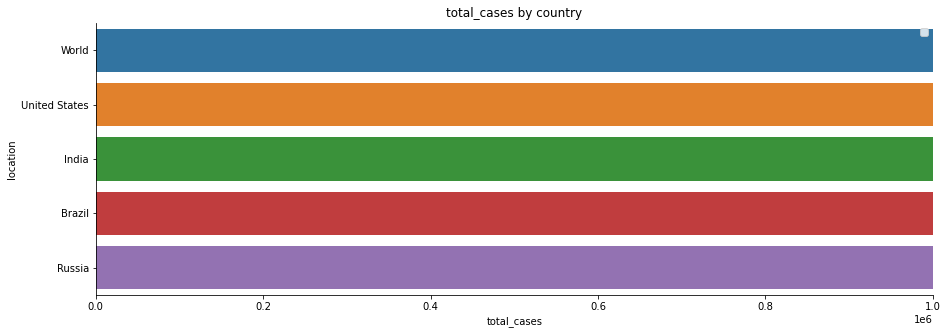

In [13]:
worldrep("total_cases")

No handles with labels found to put in legend.


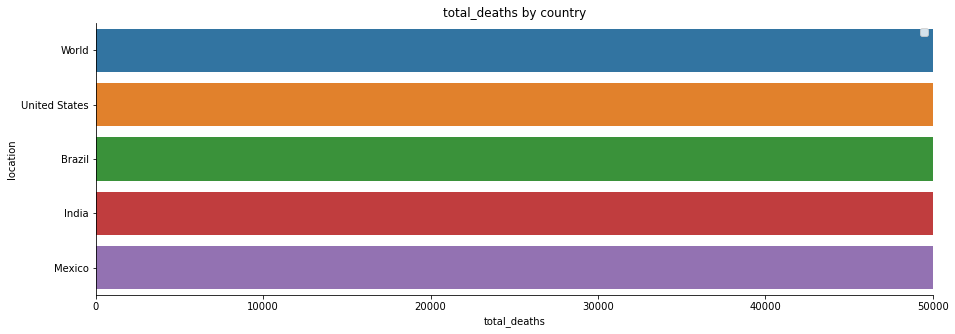

In [14]:
worldrep("total_deaths",val_larg=50000)

In [15]:
dds = df[df["date"].isin([f'{date.today()}'])]

No handles with labels found to put in legend.


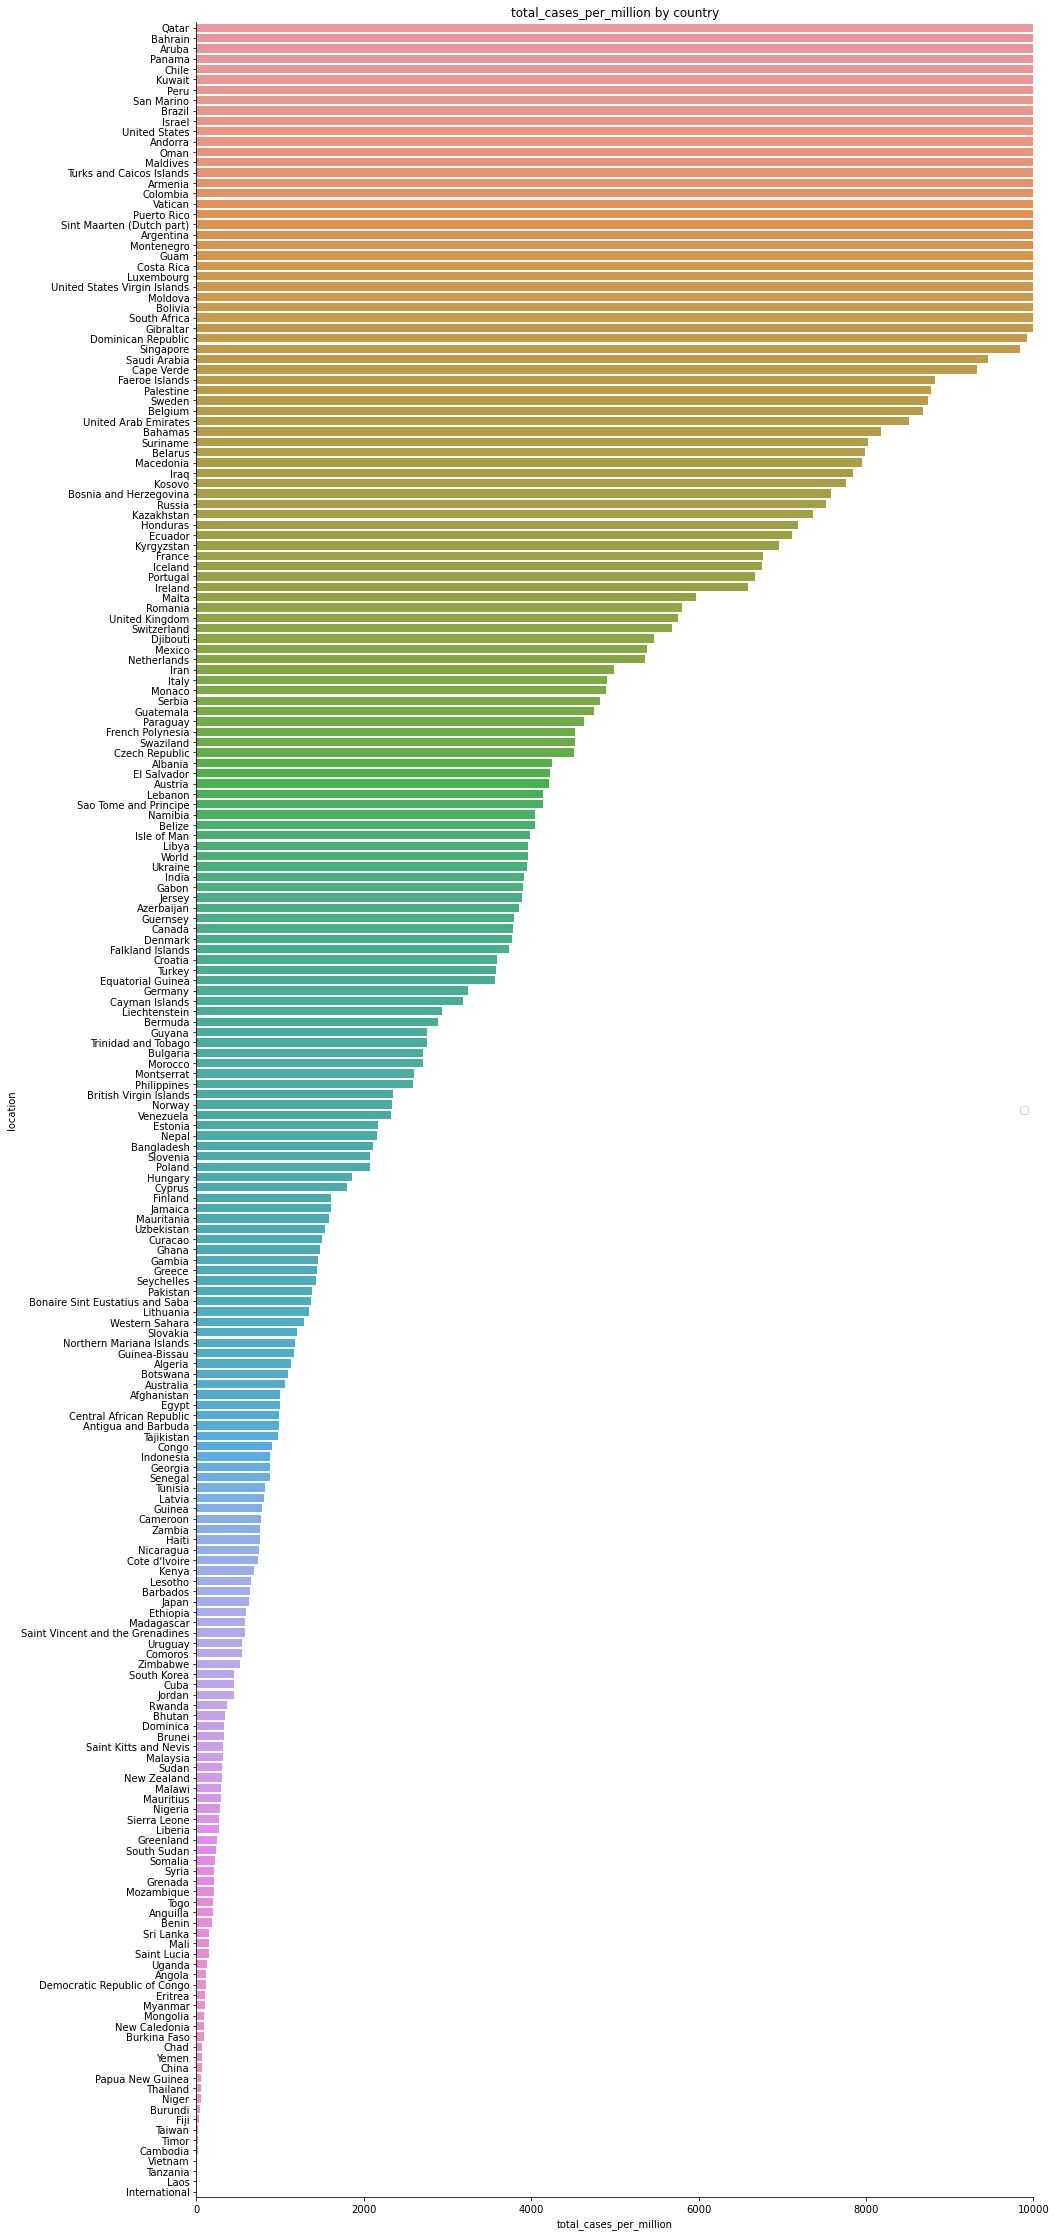

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=10000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


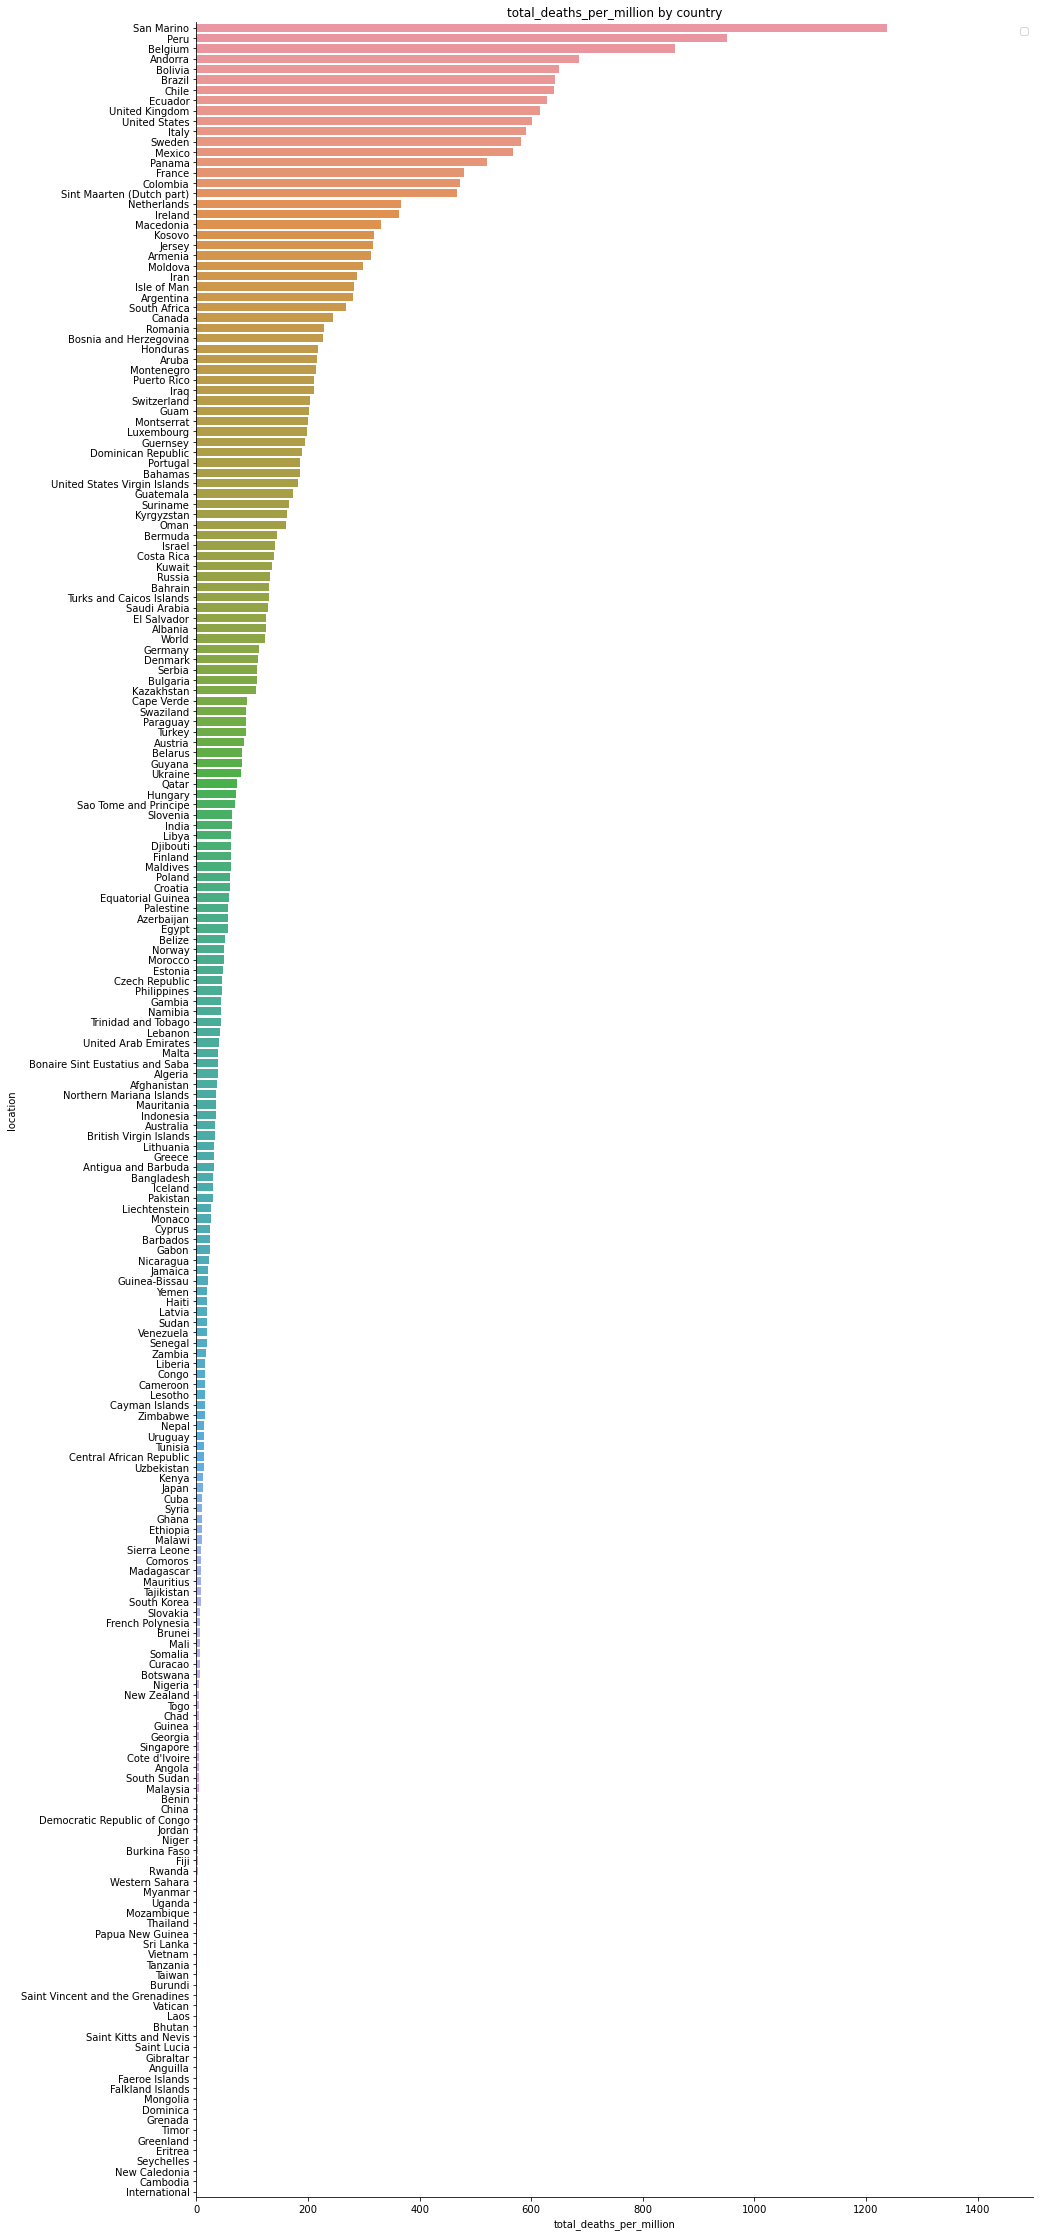

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

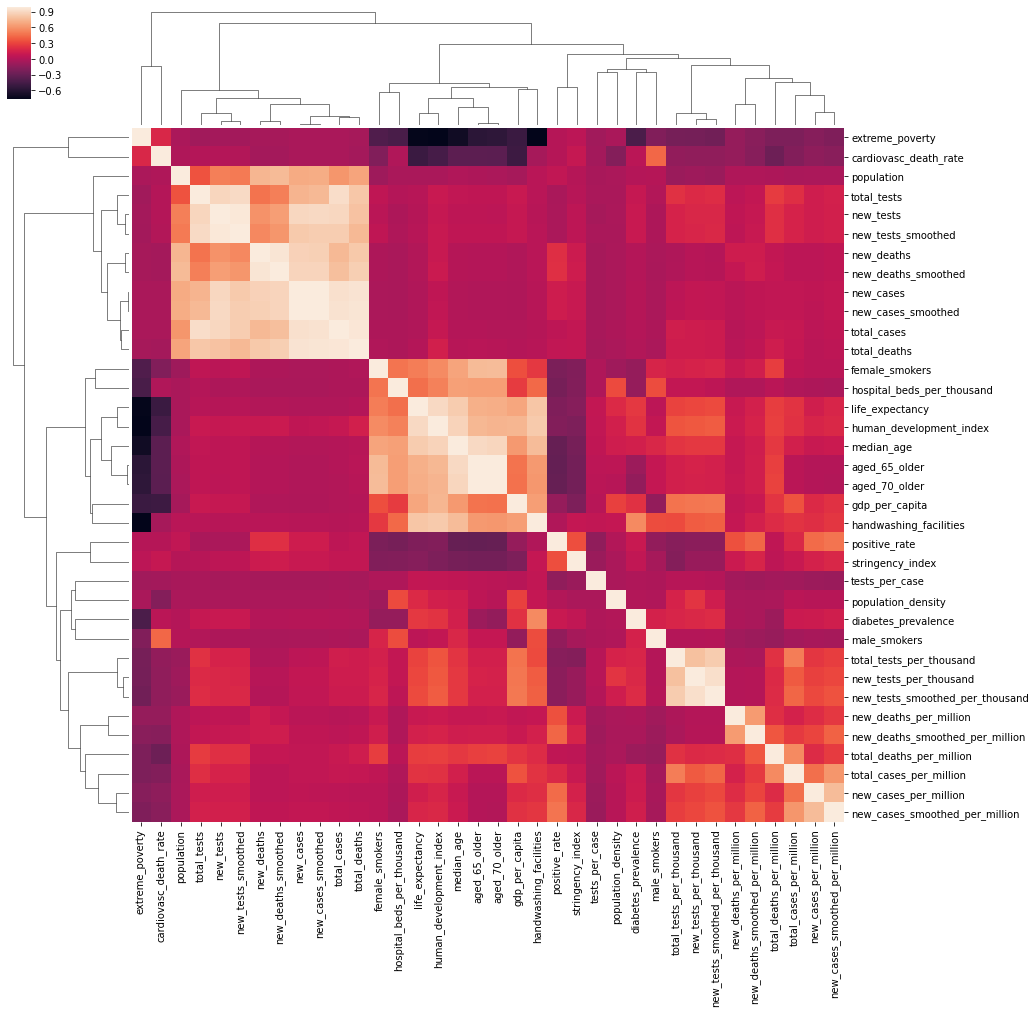

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(subject,periode,country,n_splits=3,max_iter=5000):
    
    df = pd.read_csv(f"AzureSC\\Base_Files\\full_data{date.today()}.csv")
    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(subject,periode,country):
    vals, x_train, y_train, model = createModel(subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine("total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine("total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9987019127945356 (+/- 0.0016520672387704308)
Coef :  [1.03215184e+00 8.39536197e-05 8.62005189e-05]
3 Last_days :  [[30232252 30541543 30835922]]
Today :  30835922
Prediction + :  475239
Tomorow :  31311161
                                     
--------- Total Death -----------------
                                     
R^2: 0.9996586646502901 (+/- 0.00012388810849355193)
Coef :  [0.20589807 0.39099535 0.41326578]
3 Last_days :  [[946778 952726 957790]]
Today :  957790
Prediction + :  8724
Tomorow :  966514
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: -0.11629226758592541 (+/- 1.574772387728538)
Coef :  [-0.77922842  0.79563698  0.98850009]
3 Last_days :  [[415481 428696 442194]]
Today :  442194
Prediction + :  12140
Tomorow :  454334
                                     
--------- Total Death -----------------
                                     
R^2: 0.8889583919149908 (+/- 0.14597094678807473)
Coef :  [-0.74718325  0.78836822  0.95780486]
3 Last_days :  [[31095 31249 31274]]
Today :  31274
Prediction + :  136
Tomorow :  31410
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9608724007619504 (+/- 0.03596688510671531)
Coef :  [-0.32945964 -0.0112105   1.33493549]
3 Last_days :  [[90294 90308 90333]]
Today :  90333
Prediction + :  22
Tomorow :  90355
                                     
--------- Total Death -----------------
                                     
R^2: -56.108879034758814 (+/- 80.66346155637812)
Coef :  [-0.0775608   0.01247942  1.05680994]
3 Last_days :  [[4736 4737 4737]]
Today :  4737
Prediction + :  5
Tomorow :  4742
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9313676400004658 (+/- 0.09593872505030135)
Coef :  [-0.81306726  0.89285111  0.91966055]
3 Last_days :  [[293025 294932 296569]]
Today :  296569
Prediction + :  1653
Tomorow :  298222
                                     
--------- Total Death -----------------
                                     
R^2: -0.06709741845614343 (+/- 1.486820538359433)
Coef :  [-0.82072723  0.89576655  0.92397309]
3 Last_days :  [[35658 35668 35692]]
Today :  35692
Prediction + :  26
Tomorow :  35718
                                     


In [28]:
try:
    last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Spain")
    spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp
except:
    print("No spain update")

********* For Spain **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.5758171984441822 (+/- 0.5927984269987189)
Coef :  [-0.32722055  0.20493967  1.12860502]
3 Last_days :  [[625651 640040 640040]]
Today :  640040
Prediction + :  8917
Tomorow :  648957
                                     
--------- Total Death -----------------
                                     
R^2: 0.09623534586037297 (+/- 0.9798261180305808)
Coef :  [-0.73019074  0.64145277  1.08774925]
3 Last_days :  [[30405 30495 30495]]
Today :  30495
Prediction + :  74
Tomorow :  30569
                                     


In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9655378123667434 (+/- 0.04714190029977536)
Coef :  [0.11255909 0.44767372 0.45244742]
3 Last_days :  [[6674458 6724667 6764962]]
Today :  6764962
Prediction + :  75289
Tomorow :  6840251
                                     
--------- Total Death -----------------
                                     
R^2: 0.9878559495559988 (+/- 0.015952467498179926)
Coef :  [-0.41020474  0.67460571  0.73840485]
3 Last_days :  [[197633 198589 199258]]
Today :  199258
Prediction + :  1209
Tomorow :  200467
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995802886306938 (+/- 0.0002789461667709424)
Coef :  [-0.67654344  0.82550827  0.85194512]
3 Last_days :  [[381614 385936 390358]]
Today :  390358
Prediction + :  3191
Tomorow :  393549
                                     
--------- Total Death -----------------
                                     
R^2: 0.2476772937237153 (+/- 1.0231020469568202)
Coef :  [-0.76481769  0.83014789  0.9339333 ]
3 Last_days :  [[41705 41732 41759]]
Today :  41759
Prediction + :  52
Tomorow :  41811
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.28303296226847524 (+/- 1.0130492978380525)
Coef :  [-0.77869736  0.84962207  0.9290151 ]
3 Last_days :  [[267773 270070 271415]]
Today :  271415
Prediction + :  1997
Tomorow :  273412
                                     
--------- Total Death -----------------
                                     
R^2: 0.2555832319866742 (+/- 1.0441898263543903)
Coef :  [-0.78441775  0.83916003  0.94446587]
3 Last_days :  [[9378 9384 9386]]
Today :  9386
Prediction + :  10
Tomorow :  9396
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9922221614388697 (+/- 0.009142913417899171)
Coef :  [0.33040528 0.34206738 0.3383419 ]
3 Last_days :  [[413149 416198 419043]]
Today :  419043
Prediction + :  3220
Tomorow :  422263
                                     
--------- Total Death -----------------
                                     
R^2: 0.9129392577771253 (+/- 0.12245576335680693)
Coef :  [0.12839449 0.44672041 0.43579074]
3 Last_days :  [[23808 23952 24118]]
Today :  24118
Prediction + :  217
Tomorow :  24335
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9996452597298284 (+/- 0.00026018961869379165)
Coef :  [-0.64279993  0.80566428  0.83454852]
3 Last_days :  [[298039 299810 301348]]
Today :  301348
Prediction + :  1388
Tomorow :  302736
                                     
--------- Total Death -----------------
                                     
R^2: 0.9994634781114112 (+/- 0.00032414349417361256)
Coef :  [-0.81551285  0.89541219  0.91823625]
3 Last_days :  [[7315 7377 7445]]
Today :  7445
Prediction + :  50
Tomorow :  7495
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.8798699322884299 (+/- 0.16678114784530593)
Coef :  [-0.12765104  0.51388808  0.62642007]
3 Last_days :  [[4455386 4495183 4528240]]
Today :  4528240
Prediction + :  57895
Tomorow :  4586135
                                     
--------- Total Death -----------------
                                     
R^2: 0.4606620281875853 (+/- 0.7557501479207298)
Coef :  [-0.03763899  0.48971456  0.5585565 ]
3 Last_days :  [[134935 135793 136532]]
Today :  136532
Prediction + :  1481
Tomorow :  138013
                                     


In [35]:
model_data = [world_data, french_data, italy_data, spain_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(30835922, 957790, 31311161, 966514),
 (442194, 31274, 454334, 31410),
 (296569, 35692, 298222, 35718),
 (640040, 30495, 648957, 30569),
 (6764962, 199258, 6840251, 200467),
 (90333, 4737, 90355, 4742),
 (390358, 41759, 393549, 41811),
 (271415, 9386, 273412, 9396),
 (419043, 24118, 422263, 24335),
 (301348, 7445, 302736, 7495),
 (4528240, 136532, 4586135, 138013)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()

    pop_pred.loc[0,"date"] = date.today()
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
df_pop_pred4 = popPred("Spain",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3, df_pop_pred4,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-09-20,France,454334.0,0.0,31410.0,0.0,0.0,0.0
0,2020-09-20,China,90355.0,0.0,4742.0,0.0,0.0,0.0
0,2020-09-20,Italy,298222.0,0.0,35718.0,0.0,0.0,0.0
0,2020-09-20,Spain,648957.0,0.0,30569.0,0.0,0.0,0.0
0,2020-09-20,United States,6840251.0,0.0,200467.0,0.0,0.0,0.0
0,2020-09-20,World,31311161.0,0.0,966514.0,0.0,0.0,0.0
0,2020-09-20,United Kingdom,393549.0,0.0,41811.0,0.0,0.0,0.0
0,2020-09-20,Germany,273412.0,0.0,9396.0,0.0,0.0,0.0
0,2020-09-20,Iran,422263.0,0.0,24335.0,0.0,0.0,0.0
0,2020-09-20,Turkey,302736.0,0.0,7495.0,0.0,0.0,0.0


In [40]:
predpred.to_csv(f"AzureSC\\Pred\\predDf{date.today()}.csv")